In [14]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [15]:
df = pd.read_csv("TSLA.csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [16]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

In [17]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(840, 60, 1)
X_train.shape

(740, 60, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 10s 95ms/step - loss: 0.0634
Epoch 2/100
24/24 [==============================] - 2s 95ms/step - loss: 0.0152
Epoch 3/100
24/24 [==============================] - 3s 105ms/step - loss: 0.0129
Epoch 4/100
24/24 [==============================] - 4s 147ms/step - loss: 0.0118
Epoch 5/100
24/24 [==============================] - 3s 136ms/step - loss: 0.0120
Epoch 6/100
24/24 [==============================] - 3s 136ms/step - loss: 0.0124
Epoch 7/100
24/24 [==============================] - 3s 125ms/step - loss: 0.0117
Epoch 8/100
24/24 [==============================] - 3s 139ms/step - loss: 0.0095
Epoch 9/100
24/24 [==============================] - 3s 134ms/step - loss: 0.0092
Epoch 10/100
24/24 [==============================] - 3s 122ms/step - loss: 0.0095
Epoch 11/100
24/24 [==============================] - 3s 120ms/step - loss: 0.0096
Epoch 12/100
24/24 [==============================] - 3s 122ms/step - loss: 0.0093
Epoch 13/100
2

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (300, 60, 1)
X_test.shape

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

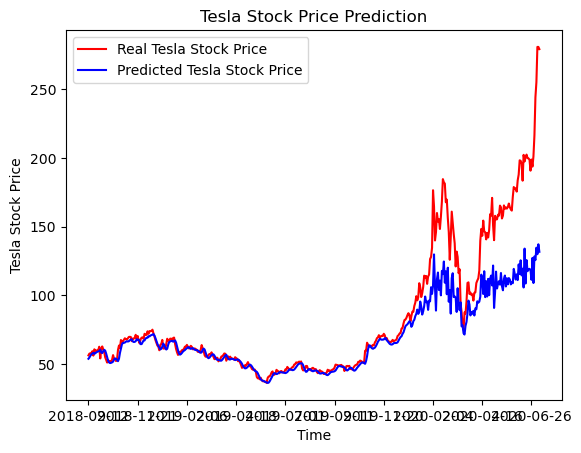

In [24]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()